<a href="https://colab.research.google.com/github/hemalmewan/Causal-Inference-for-Medical-Images/blob/main/CNN_chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

## Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset,DataLoader
import cv2


## Download the Dataset

In [3]:
od.download("https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mewanmunasinghe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized


100%|██████████| 2.30G/2.30G [00:18<00:00, 130MB/s]


## Import the Dataset

In [4]:
data_entry=pd.read_csv('/content/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

In [5]:
data_entry.shape

(112120, 12)

In [6]:
data_entry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


## Get the Labels from the Dataset

In [7]:
all_labels=set()

for label_str in data_entry['Finding Labels']:
  for label in label_str.split('|'):
    all_labels.add(label.strip())

all_labels=sorted(all_labels)

In [8]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

## Load and Plot first 10 images from the Dataset

In [9]:
images_path=[]
path='/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224'

for file in data_entry['Image Index']:
  images_path.append(os.path.join(path,file))

In [10]:
images_path[:10]

['/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000001_000.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000001_001.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000001_002.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000002_000.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_000.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_001.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_002.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_003.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_004.png',
 '/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224/00000003_005.png']

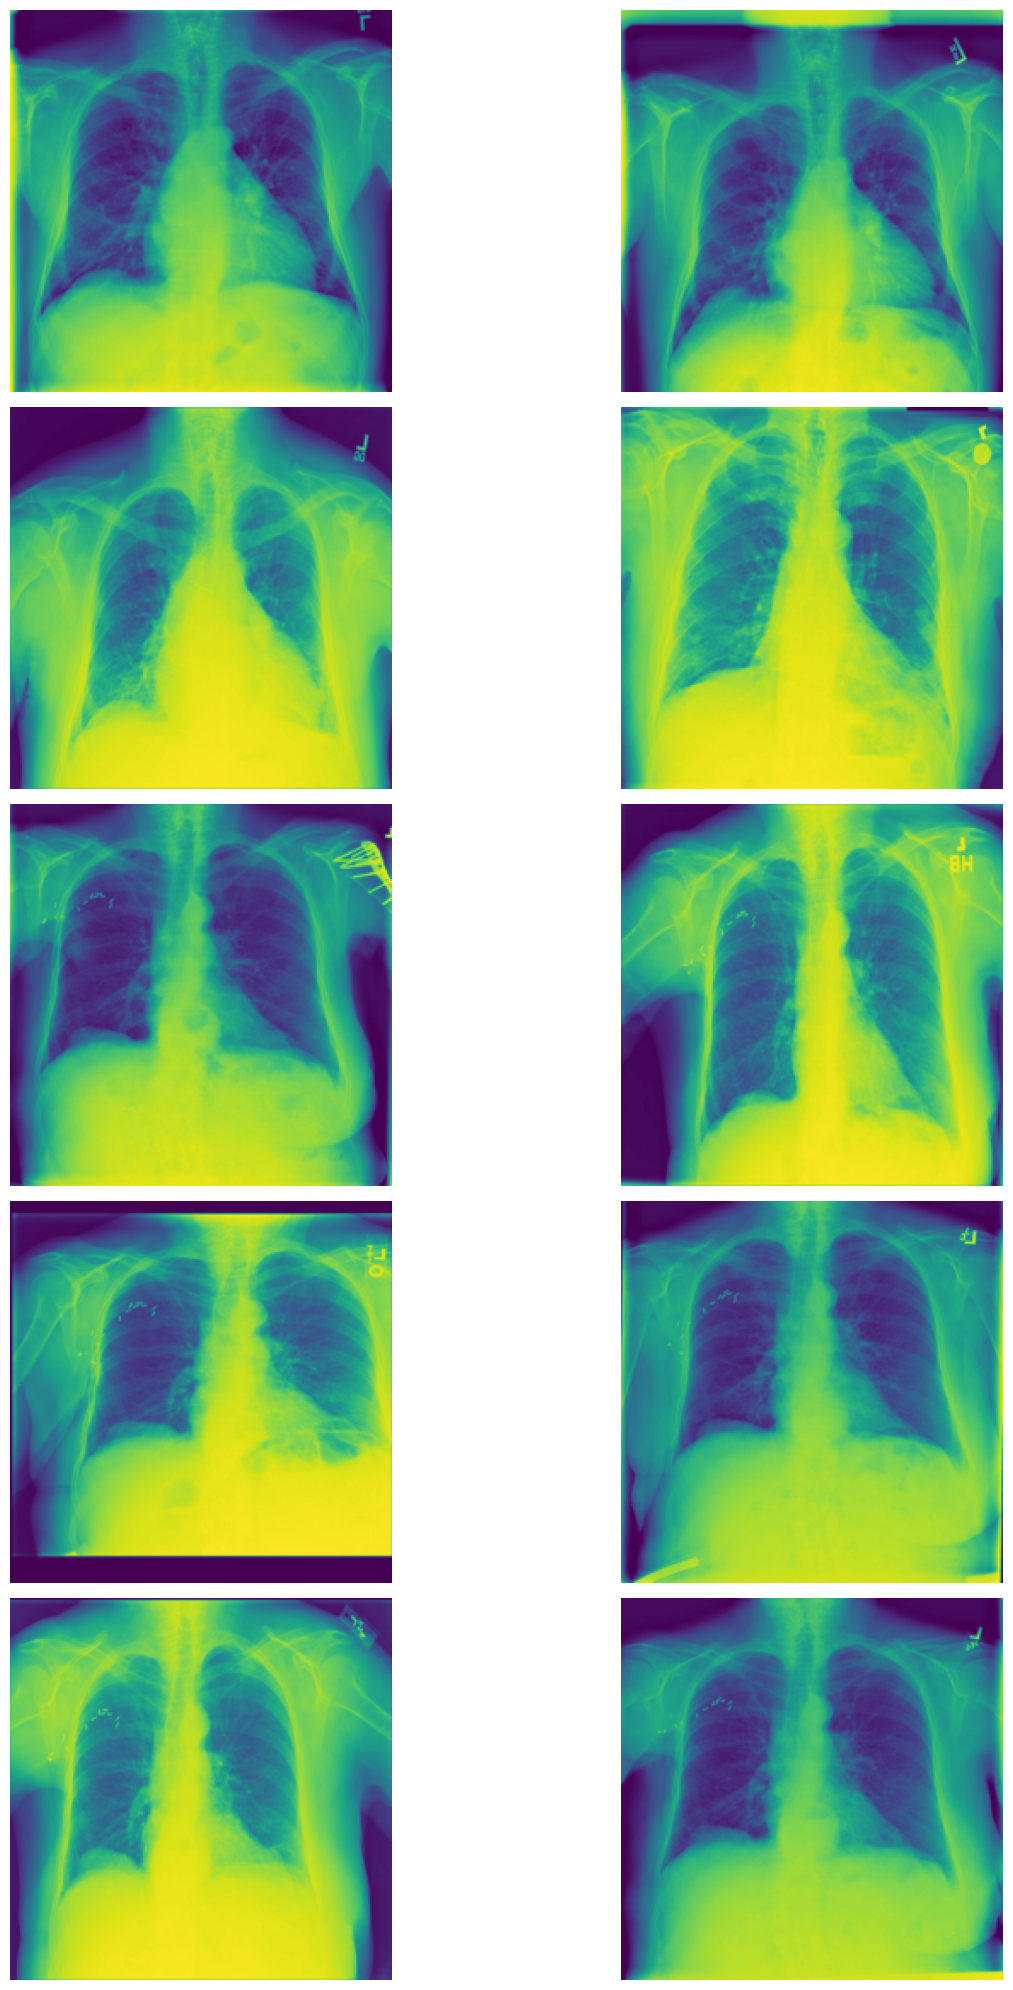

In [11]:
fig,axes=plt.subplots(5,2,figsize=(15,20))
axes=axes.flatten()
for idx,image in enumerate(images_path):
  if idx>=10:
    break
  axes[idx].imshow(plt.imread(image))
  axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Count the number of Lables in each image

In [12]:
classes=[]
for labels in data_entry['Finding Labels']:
  for label in labels.split("|"):
    classes.append(label)

classes=pd.Series(classes).value_counts()

In [13]:
classes

,count
No Finding,60412
Infiltration,19870
Effusion,13307
Atelectasis,11535
Nodule,6323
Mass,5746
Pneumothorax,5298
Consolidation,4667
Pleural_Thickening,3385
Cardiomegaly,2772


## Apply Multi Hot Encoding

In [14]:
data_entry['labels']=data_entry['Finding Labels'].apply(lambda x:x.split('|'))
mlb=MultiLabelBinarizer(classes=all_labels)
label_matrix=mlb.fit_transform(data_entry['labels'])
label_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
label_matrix.shape

(112120, 15)

## Image Preprocessing and Label Preprocessing

In [16]:
class Dataset(object):

  def __getItem__(self,index):
    return NotImplementedError

  def __len__(self):
    return NotImplementedError


In [17]:
class Preprocessing(Dataset):

  def __init__(self):
    self.labels=[]
    self.images=[]

    data_path="/content/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv"
    path="/content/nih-chest-x-ray-14-224x224-resized/images-224/images-224"

    df=pd.read_csv(data_path)

    for label_str in df['Finding Labels']:
        self.labels.append(label_str.split("|"))

    image_names=df['Image Index'].tolist()
    for image_name in image_names[0:7000]: ##get the sample of the images(7000)
      image_path=os.path.join(path,image_name)
      image=cv2.imread(image_path)

      if image is None:
        print(f"Warning Image path could not find{image_path}")
        continue

      elif len(image.shape)==2:
        copy_image=[image.copy() for _ in range(3)]
        image=np.stack(copy_image,axis=-1)   ## Make the image which contein 3 channels

      image=cv2.resize(image,(224,224)) ##resize all images
      self.images.append(image)
    self.images=np.array(self.images)

    self.normalize()

  def normalize(self):
      self.images=self.images/255.0 ##make the all images between 0 and 1

  def __len__(self):
      return self.images.shape[0]

  def __getitem__(self,index):
    details={'Image':self.images[index],'Labels':self.labels[index]}
    return details


In [18]:
obj=Preprocessing()

In [19]:
obj.images.shape ##shape of the 7000 images

(7000, 224, 224, 3)

In [40]:
label_data=label_matrix[:7000] ##label matrix

In [41]:
image_preprocessing_data=obj.images ##get the all preprocess images(7000)

## Apply DataLoader